in this notebook I am plotting the fermi best fit

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
import os

from gammapy.data import EventList
from gammapy.datasets import MapDataset
from gammapy.irf import PSFMap, EDispKernelMap
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    PointSpatialModel,
    SkyModel,
    TemplateSpatialModel,
    PowerLawNormSpectralModel,
    LogParabolaSpectralModel,
    Models,
    SuperExpCutoffPowerLaw4FGLSpectralModel,
    create_fermi_isotropic_diffuse_model,
)
from gammapy.modeling import Fit

In [2]:
dataset_names = ['low_energy', 'med_energy', 'hi_energy']
main_path = '/home/woody/caph/mppi062h/woody_output/final/fermilat/'
iso_list = ['iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_ULTRACLEANVETO_V3_v1.txt', 'iso_P8R3_SOURCE_V3_v1.txt']

N_bin_met = 8
radius_list = [12, 5, 5]
dataset_e_edges = [100, 600, 4e3, 1e6] #u.MeV
thresh_idx = 20

time_label=['2008-2010', '2010-2012', '2012-2014', '2014-2016', '2016-2018', '2018-2020', '2020-2022']
met_values = [246823875, 309895876, 373054277, 436126277, 499284678, 562356679, 625515079, 678426195]

with open('/home/vault/caph/mppi062h/repositories/GC/FermiLAT/source_list.txt') as f:
    source_list = f.readlines()

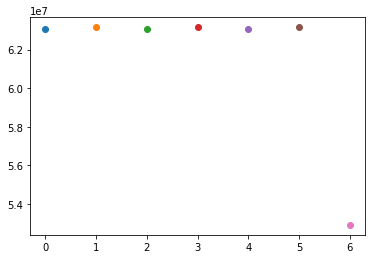

In [3]:
for i in range(N_bin_met-1):
    plt.scatter(i, met_values[i+1]-met_values[i], label=time_label[i])

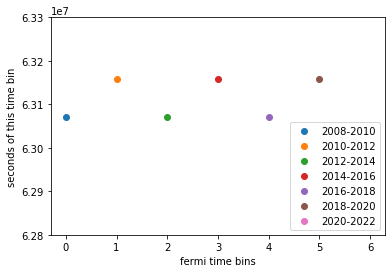

In [4]:
for i in range(N_bin_met-1):
    plt.scatter(i, met_values[i+1]-met_values[i], label=time_label[i])
plt.ylim(6.28e7, 6.33e7)
plt.ylabel('seconds of this time bin')
plt.xlabel('fermi time bins')
plt.legend(loc='lower right')

In [5]:
import csv

names= ['Fermi', 'HESS']
colors = ['red', 'blue']
unit_y= "E"+r"$^2$"+"dN/dE (erg/cm^2/s)"
unit_x = 'eV'

flux_points = []
for name in names:
    with open(f'/home/vault/caph/mppi062h/repositories/GC/gamera/data_from_paper/{name}.csv', newline='') as csvfile:
        reader = csv.reader(csvfile)
        fp_name = []
        for row in reader:
            fp_name.append(row)
    flux_points.append(np.asarray(fp_name, dtype=float))

In [5]:
def get_datasets_binmet_modelversion(modelversion):
    datasets_binmet = []
    for dataset_idx, dataset_name in enumerate(dataset_names):
        datasets_binmet.append([])
        if dataset_idx != 0:
            for n_bin_met in range(N_bin_met-1):
                folder = f'{main_path}/{dataset_name}/{n_bin_met}_bin_met'
                dataset = MapDataset.read(f'{folder}/fermi_dataset.fits', name=f'dataset_idx={dataset_idx}')

                dataset.mask_safe = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
                dataset.mask_safe &= dataset.counts.geom.region_mask(f"galactic;circle(0, 0, {radius_list[dataset_idx]})")

                m1 = (dataset.counts.geom.axes['energy'].center.value > dataset_e_edges[dataset_idx])
                m2 = (dataset.counts.geom.axes['energy'].center.value < dataset_e_edges[dataset_idx+1])
                mask = m1 & m2
                dataset.mask_safe.data[~mask] = 0
                
                # opening the source maps, done before
                dataset.background = Map.from_geom(geom=dataset.counts.geom, data=np.zeros_like(dataset.counts.data)) 
                for source_name in source_list[:thresh_idx]:
                    if source_name[:-1] != '4FGL J1745.6-2859':
                        temp = MapDataset.read(f'{folder}/sources_dataset/{source_name[5:-1]}.fits')
                        dataset.background.data += temp.counts.data

                if modelversion == 'separated':
                    model_file_name = 'fitted_model.yml'
                elif modelversion == 'joint':
                    model_file_name = 'fitted_model_joint.yml'
                    
                model_path = f'{main_path}/{dataset_names[dataset_idx]}/{n_bin_met}_bin_met/{model_file_name}'
                if os.path.exists(model_path):
                    dataset.models = Models.read(model_path)
                else:
                    print(dataset_idx, n_bin_met)

                datasets_binmet[dataset_idx].append(dataset)
    return datasets_binmet

# modelversion=joint

In [6]:
datasets_binmet = get_datasets_binmet_modelversion(modelversion='joint')

Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr

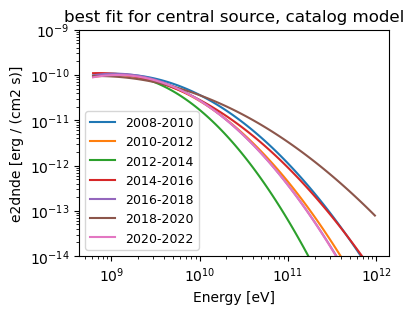

In [8]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

dataset_idx = 1

if dataset_idx != 0:
    for n_bin_met in range(N_bin_met-1):
        label=None
        if dataset_idx==1:
            label=time_label[n_bin_met]

        datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
            energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
plt.ylim(1e-14, 1e-9)
plt.legend(prop={'size': 9})
plt.title('best fit for central source, catalog model')
plt.show()

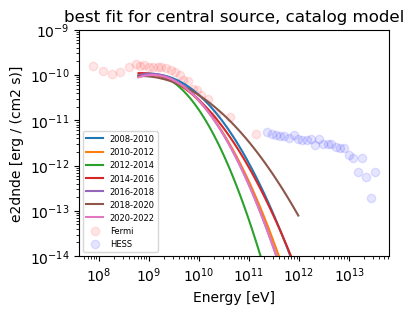

In [9]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)
dataset_idx=1
if dataset_idx != 0:
    for n_bin_met in range(N_bin_met-1):
        label=None
        if dataset_idx==1:
            label=time_label[n_bin_met]

        datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
            energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
for i, fp_name in enumerate(flux_points):
    ax.scatter(fp_name[:, 0], fp_name[:, 1], color=colors[i], label=names[i], alpha=0.1)
plt.ylim(1e-14, 1e-9)
plt.legend(prop={'size': 6})
plt.title('best fit for central source, catalog model')
plt.show()

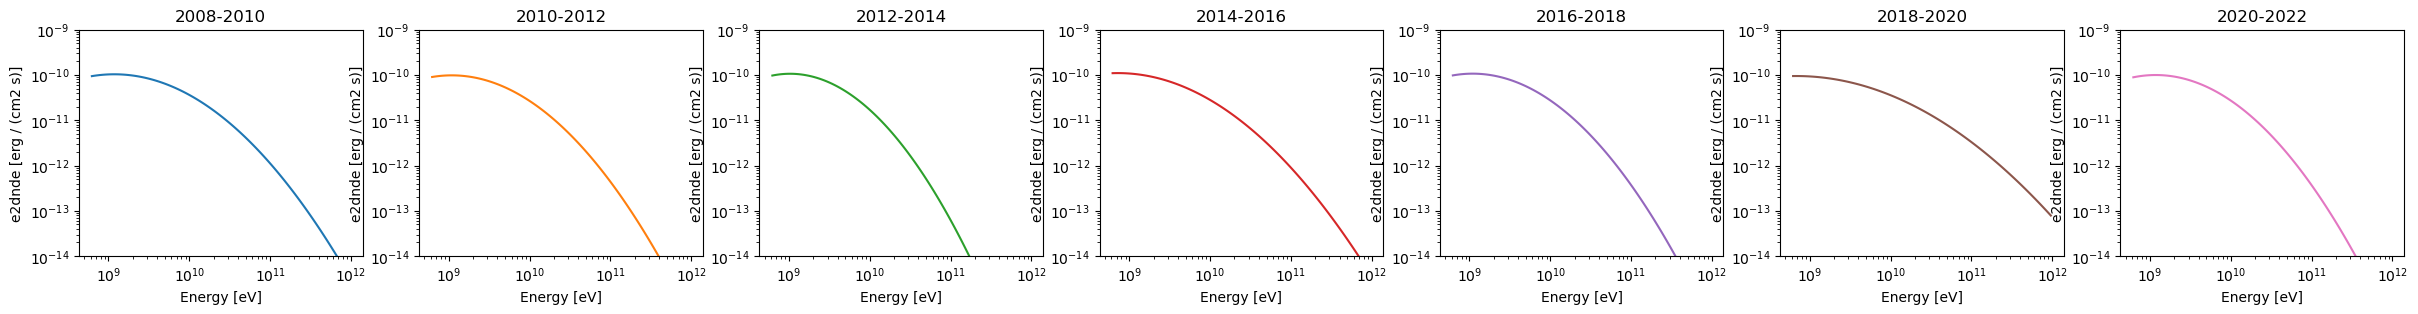

In [10]:
fig, ax = plt.subplots(1,7, figsize=(30, 3), dpi=100)
dataset_idx=1
for n_bin_met in range(N_bin_met-1):
    datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
        energy_bounds=[6e2, 1e6]*u.MeV, label=n_bin_met, 
        color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
        ax=ax[n_bin_met])
    ax[n_bin_met].set_ylim(1e-14, 1e-9)
    ax[n_bin_met].set_title(time_label[n_bin_met])
#plt.title('connecting low and high energy, per time bin')
plt.show()

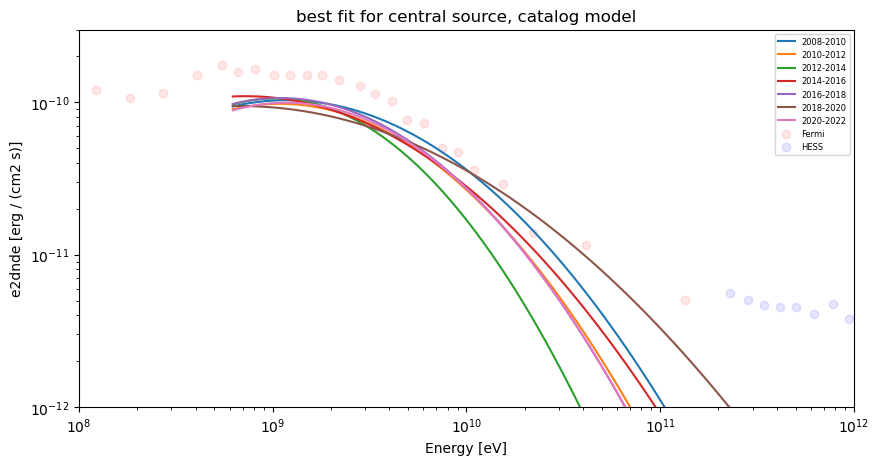

In [11]:
fig, ax = plt.subplots(1,1, figsize=(10, 5), dpi=100)
dataset_idx=1
if dataset_idx != 0:
    for n_bin_met in range(N_bin_met-1):
        label=None
        if dataset_idx==1:
            label=time_label[n_bin_met]

        datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
            energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
for i, fp_name in enumerate(flux_points):
    ax.scatter(fp_name[:, 0], fp_name[:, 1], color=colors[i], label=names[i], alpha=0.1)
plt.ylim(1e-12, 3e-10)
plt.xlim(1e8, 1e12)

plt.legend(prop={'size': 6})
plt.title('best fit for central source, catalog model')
plt.show()

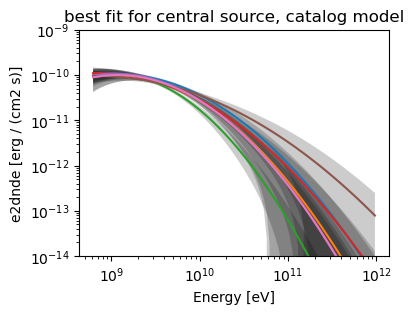

In [12]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

dataset_idx = 1

if dataset_idx != 0:
    for n_bin_met in range(N_bin_met-1):
        label=None
        if dataset_idx==1:
            label=time_label[n_bin_met]

        datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot_error(energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
        datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
            energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
plt.ylim(1e-14, 1e-9)
#plt.legend(prop={'size': 9})
plt.title('best fit for central source, catalog model')
plt.show()

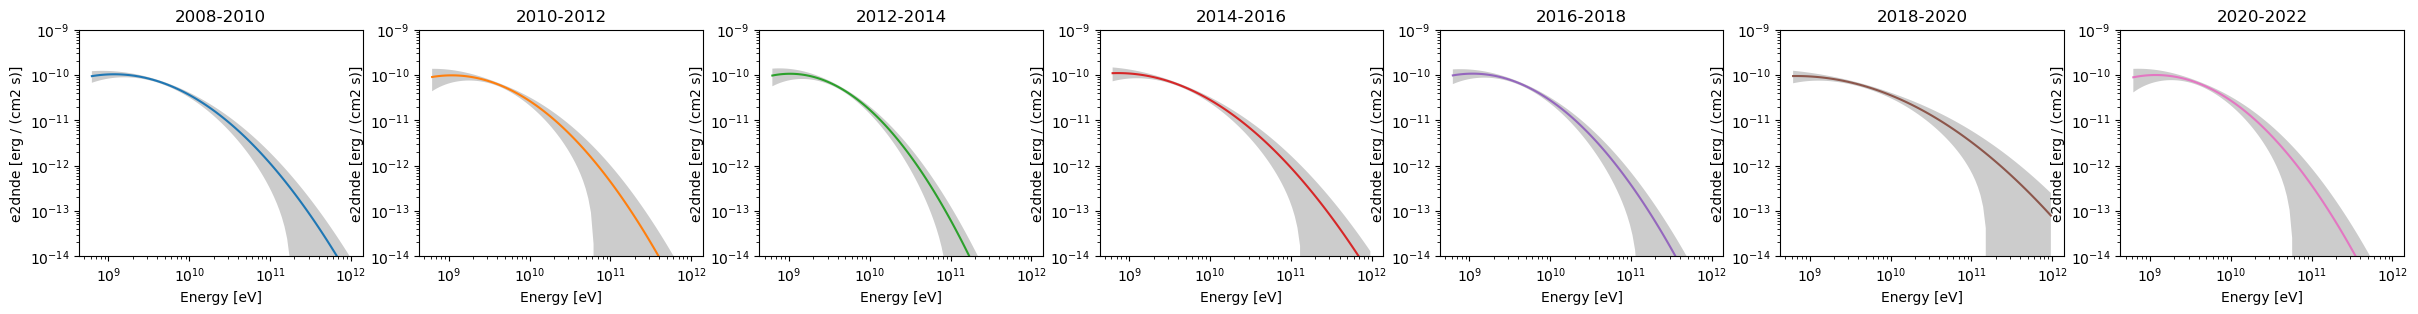

In [13]:
fig, ax = plt.subplots(1,7, figsize=(30, 3), dpi=100)
dataset_idx=1
for n_bin_met in range(N_bin_met-1):
    datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot_error(energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax[n_bin_met])
    datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
        energy_bounds=[6e2, 1e6]*u.MeV, label=n_bin_met, 
        color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
        ax=ax[n_bin_met])
    ax[n_bin_met].set_ylim(1e-14, 1e-9)
    ax[n_bin_met].set_title(time_label[n_bin_met])
#plt.title('connecting low and high energy, per time bin')
plt.show()

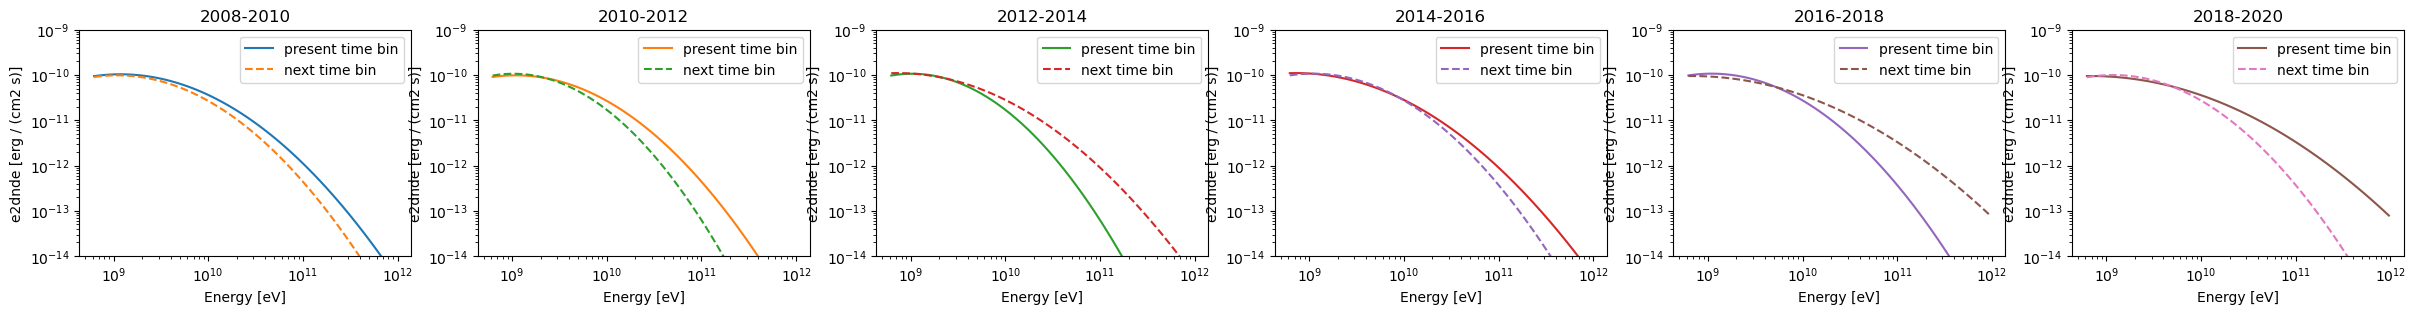

In [38]:
fig, ax = plt.subplots(1,6, figsize=(30, 3), dpi=100)
dataset_idx=1
for n_bin_met in range(N_bin_met-2):
    datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
        energy_bounds=[6e2, 1e6]*u.MeV, 
        color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
        ax=ax[n_bin_met], label='present time bin')
    
    datasets_binmet[dataset_idx][n_bin_met+1].models['4FGL J1745.6-2859'].spectral_model.plot(
        energy_bounds=[6e2, 1e6]*u.MeV,
        color=f'C{n_bin_met+1}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
        ax=ax[n_bin_met], label='next time bin', ls='--')
    
    ax[n_bin_met].set_ylim(1e-14, 1e-9)
    ax[n_bin_met].set_title(time_label[n_bin_met])
#plt.title('connecting low and high energy, per time bin')
    ax[n_bin_met].legend()
plt.show()

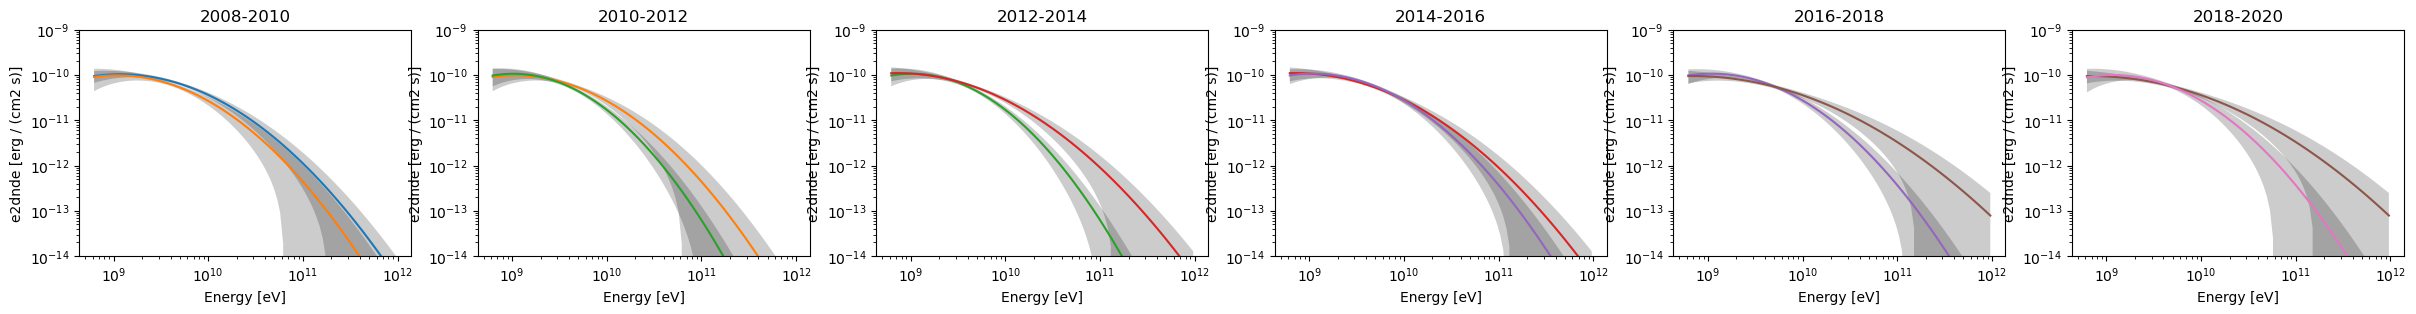

In [14]:
fig, ax = plt.subplots(1,6, figsize=(30, 3), dpi=100)
dataset_idx=1
for n_bin_met in range(N_bin_met-2):
    datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot_error(energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax[n_bin_met])
    datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
        energy_bounds=[6e2, 1e6]*u.MeV, label=n_bin_met, 
        color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
        ax=ax[n_bin_met])
    
    datasets_binmet[dataset_idx][n_bin_met+1].models['4FGL J1745.6-2859'].spectral_model.plot_error(energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax[n_bin_met])
    datasets_binmet[dataset_idx][n_bin_met+1].models['4FGL J1745.6-2859'].spectral_model.plot(
        energy_bounds=[6e2, 1e6]*u.MeV, label=n_bin_met, 
        color=f'C{n_bin_met+1}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
        ax=ax[n_bin_met])
    
    ax[n_bin_met].set_ylim(1e-14, 1e-9)
    ax[n_bin_met].set_title(time_label[n_bin_met])
#plt.title('connecting low and high energy, per time bin')
plt.show()

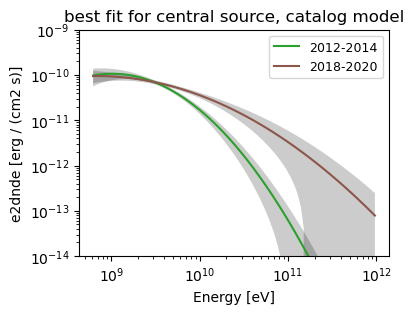

In [15]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

dataset_idx = 1

if dataset_idx != 0:
    for n_bin_met in [2, 5]:
        label=None
        if dataset_idx==1:
            label=time_label[n_bin_met]

        datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot_error(energy_bounds=[6e2, 1e6]*u.MeV, 
            sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
        datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
            energy_bounds=[6e2, 1e6]*u.MeV, label=label, 
            color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
        ax=ax)
plt.ylim(1e-14, 1e-9)
plt.legend(prop={'size': 9})
plt.title('best fit for central source, catalog model')
plt.show()

Text(0, 0.5, 'norm isotropic emission')

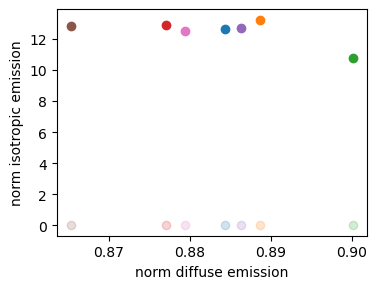

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

for n_bin_met in range(N_bin_met-1):
    diff_norm = datasets_binmet[dataset_idx][n_bin_met].models['diffuse-iem'].parameters['norm'].value
    iso_norm_1 = datasets_binmet[1][n_bin_met].models['fermi-diffuse-iso_1'].parameters['norm'].value
    iso_norm_2 = datasets_binmet[2][n_bin_met].models['fermi-diffuse-iso_2'].parameters['norm'].value
    ax.scatter(diff_norm, iso_norm_1, color=f'C{n_bin_met}')
    ax.scatter(diff_norm, iso_norm_2, color=f'C{n_bin_met}', alpha=0.2)   
plt.xlabel('norm diffuse emission')
plt.ylabel('norm isotropic emission')

Text(0.5, 0, 'time bin')

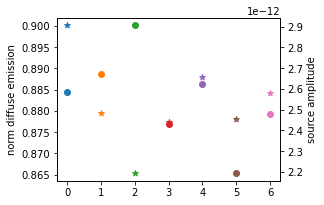

In [17]:
fig, ax = plt.subplots(figsize=(4, 3))
ax2 = ax.twinx()

for n_bin_met in range(N_bin_met-1):
    diff_norm = datasets_binmet[dataset_idx][n_bin_met].models['diffuse-iem'].parameters['norm'].value
    ax.scatter(n_bin_met, diff_norm,color=f'C{n_bin_met}')
    ax.set_ylabel('norm diffuse emission')  
    
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    ax2.scatter(n_bin_met, source_norm,color=f'C{n_bin_met}', marker='*')
    ax2.set_ylabel('source amplitude')  
    ax2.tick_params('y')
ax2.set_xlabel('time bin')

Text(0.5, 0, 'source amplitude')

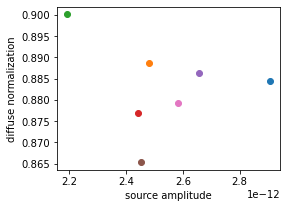

In [18]:
fig, ax = plt.subplots(figsize=(4, 3))

for n_bin_met in range(N_bin_met-1):
    diff_norm = datasets_binmet[dataset_idx][n_bin_met].models['diffuse-iem'].parameters['norm'].value
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    ax.scatter(source_norm, diff_norm,color=f'C{n_bin_met}')
ax.set_ylabel('diffuse normalization')  
ax.set_xlabel('source amplitude')  

Text(0.5, 0, 'time bin')

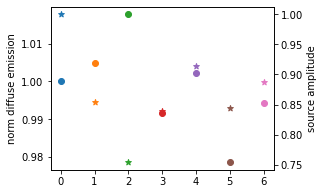

In [19]:
fig, ax = plt.subplots(figsize=(4, 3))
ax2 = ax.twinx()

for n_bin_met in range(N_bin_met-1):
    diff_norm = datasets_binmet[dataset_idx][n_bin_met].models['diffuse-iem'].parameters['norm'].value
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    
    if n_bin_met ==0:
        diff_norm_ref = diff_norm
        source_norm_ref = source_norm
        
    ax.scatter(n_bin_met, diff_norm/diff_norm_ref,color=f'C{n_bin_met}')
    ax.set_ylabel('norm diffuse emission')  
    
    ax2.scatter(n_bin_met, source_norm/source_norm_ref,color=f'C{n_bin_met}', marker='*')
    ax2.set_ylabel('source amplitude')  
    ax2.tick_params('y')
ax2.set_xlabel('time bin')

In [20]:
print(datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'])

SkyModel

  Name                      : 4FGL J1745.6-2859
  Datasets names            : None
  Spectral model type       : LogParabolaSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    amplitude               :   2.58e-12   +/- 2.6e-13 1 / (cm2 MeV s)
    reference    (frozen)   :   3975.235       MeV         
    alpha                   :      2.690   +/-    0.18             
    beta                    :      0.284   +/-    0.12             
    lon_0        (frozen)   :    266.415       deg         
    lat_0        (frozen)   :    -28.997       deg         




Text(0.5, 0, 'source amplitude')

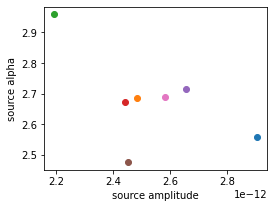

In [21]:
fig, ax = plt.subplots(figsize=(4, 3))

for n_bin_met in range(N_bin_met-1):
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    source_alpha = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['alpha'].value
    source_beta = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['beta'].value
    
    ax.scatter(source_norm, source_alpha,color=f'C{n_bin_met}')
ax.set_ylabel('source alpha')  
ax.set_xlabel('source amplitude')  

Text(0.5, 0, 'source amplitude')

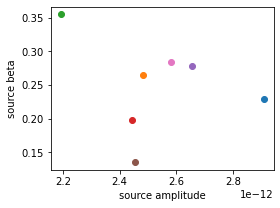

In [22]:
fig, ax = plt.subplots(figsize=(4, 3))

for n_bin_met in range(N_bin_met-1):
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    source_alpha = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['alpha'].value
    source_beta = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['beta'].value
    
    ax.scatter(source_norm, source_beta,color=f'C{n_bin_met}')
ax.set_ylabel('source beta')  
ax.set_xlabel('source amplitude')  

Text(0.5, 0, 'source alpha')

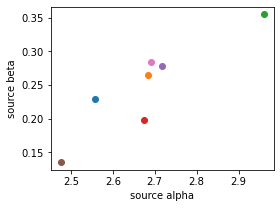

In [23]:
fig, ax = plt.subplots(figsize=(4, 3))

for n_bin_met in range(N_bin_met-1):
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    source_alpha = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['alpha'].value
    source_beta = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['beta'].value
    
    ax.scatter(source_alpha, source_beta,color=f'C{n_bin_met}')
ax.set_ylabel('source beta')  
ax.set_xlabel('source alpha')  

Text(0.5, 0, 'time bin')

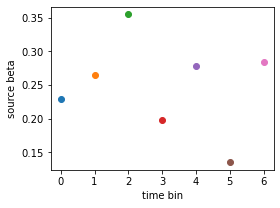

In [24]:
fig, ax = plt.subplots(figsize=(4, 3))

for n_bin_met in range(N_bin_met-1):
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    source_alpha = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['alpha'].value
    source_beta = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['beta'].value
    
    ax.scatter(n_bin_met, source_beta,color=f'C{n_bin_met}')
ax.set_ylabel('source beta')  
ax.set_xlabel('time bin')  

Text(0.5, 0, 'time bin')

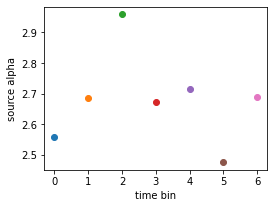

In [25]:
fig, ax = plt.subplots(figsize=(4, 3))

for n_bin_met in range(N_bin_met-1):
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    source_alpha = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['alpha'].value
    source_beta = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['beta'].value
    
    ax.scatter(n_bin_met, source_alpha,color=f'C{n_bin_met}')
ax.set_ylabel('source alpha')  
ax.set_xlabel('time bin')  

Text(0.5, 0, 'time bin')

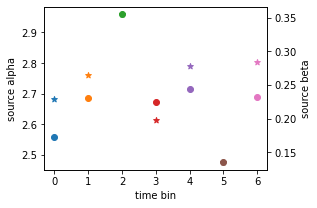

In [26]:
fig, ax = plt.subplots(figsize=(4, 3))
ax2 = ax.twinx()

for n_bin_met in range(N_bin_met-1):
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
    source_alpha = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['alpha'].value
    source_beta = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['beta'].value

    diff_norm = datasets_binmet[dataset_idx][n_bin_met].models['diffuse-iem'].parameters['norm'].value
    source_norm = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].parameters['amplitude'].value
            
    ax.scatter(n_bin_met, source_alpha,color=f'C{n_bin_met}')
    ax.set_ylabel('source alpha')  
    
    ax2.scatter(n_bin_met, source_beta,color=f'C{n_bin_met}', marker='*')
    ax2.set_ylabel('source beta')  
    ax2.tick_params('y')
ax.set_xlabel('time bin')

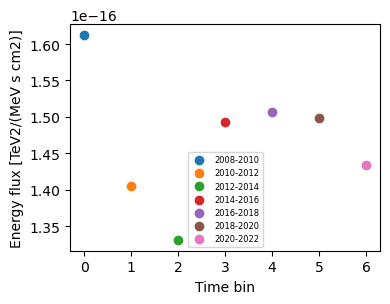

In [34]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

if dataset_idx != 0:
    for n_bin_met in range(N_bin_met-1):
        e_flux = datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.energy_flux(6e2*u.MeV, 1*u.TeV)
        ax.scatter(n_bin_met, e_flux, label=time_label[n_bin_met])
        
ax.set_ylabel('Energy flux [TeV2/(MeV s cm2)]')
ax.set_xlabel('Time bin')
plt.legend(prop={'size': 6}, loc='lower center')

In [43]:
e_flux

<Quantity 1.43431568e-16 TeV2 / (cm2 MeV s)>

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


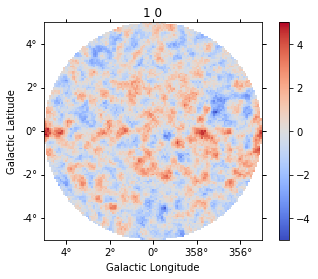

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


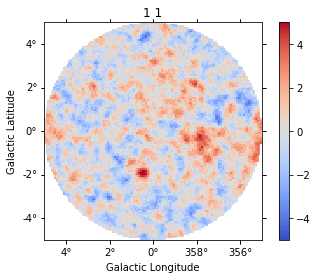

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


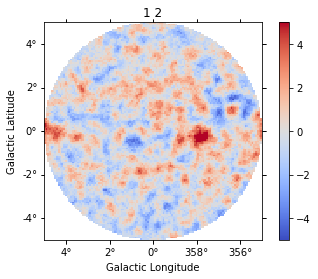

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


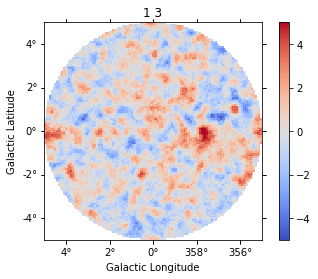

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


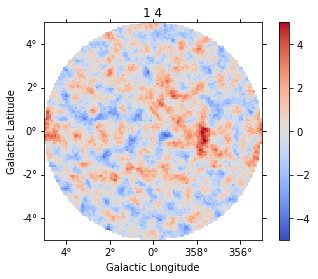

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


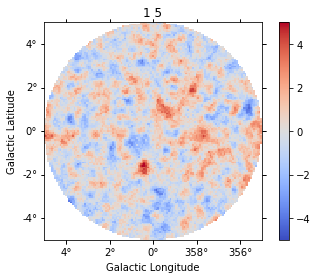

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


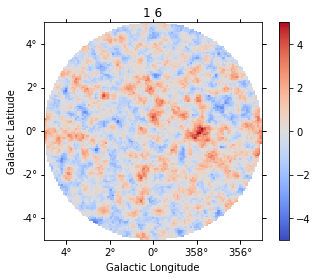

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


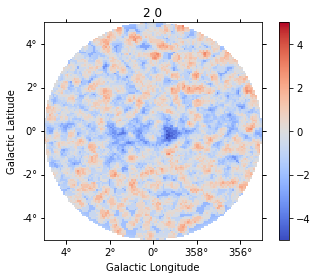

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


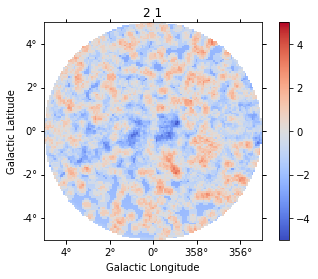

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


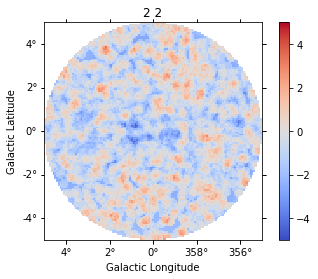

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


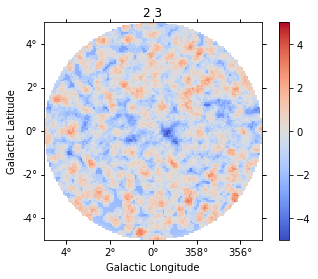

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


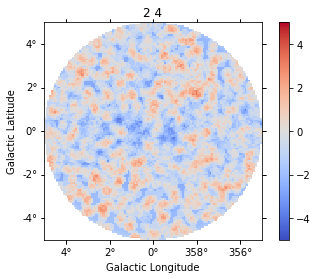

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


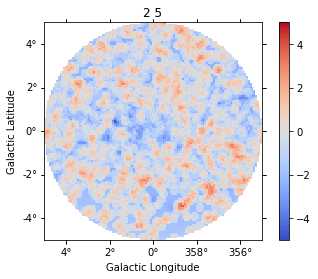

Position <SkyCoord (ICRS): (ra, dec) in deg
    (0., 0.)> is outside valid IRF map range, using nearest IRF defined within
/home/woody/caph/mppi062h/software/anaconda/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


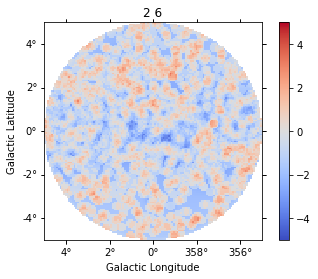

In [7]:
from gammapy.estimators import ExcessMapEstimator

for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):

            estimator = ExcessMapEstimator(
                correlation_radius="0.2 deg",
                selection_optional=[],
                energy_edges=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV,
            )
            result = estimator.run(datasets_binmet[dataset_idx][n_bin_met])
            
            result["sqrt_ts"].plot(cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5)
            plt.title(f'{dataset_idx} {n_bin_met}')
            plt.show()

Text(0, 0.5, 'norm isotropic emission')

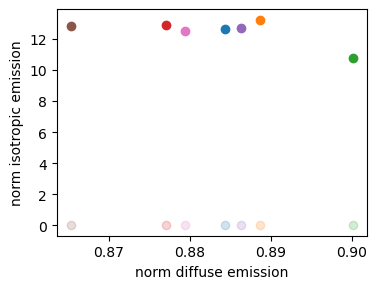

In [39]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)
dataset_idx = 1

if dataset_idx != 0:
    for n_bin_met in range(N_bin_met-1):
        label=None
        if dataset_idx==1:
            label=time_label[n_bin_met]
            diff_norm = datasets_binmet[dataset_idx][n_bin_met].models['diffuse-iem'].parameters['norm'].value
            iso_norm_1 = datasets_binmet[1][n_bin_met].models['fermi-diffuse-iso_1'].parameters['norm'].value
            iso_norm_2 = datasets_binmet[2][n_bin_met].models['fermi-diffuse-iso_2'].parameters['norm'].value
            ax.scatter(diff_norm, iso_norm_1, color=f'C{n_bin_met}')
            ax.scatter(diff_norm, iso_norm_2, color=f'C{n_bin_met}', alpha=0.2)   
plt.xlabel('norm diffuse emission')
plt.ylabel('norm isotropic emission')

# modelversion= separated

In [5]:
datasets_binmet = get_datasets_binmet_modelversion(modelversion='separated')

Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1
Parameter value not defined. Using default value: 1.0 sr-1


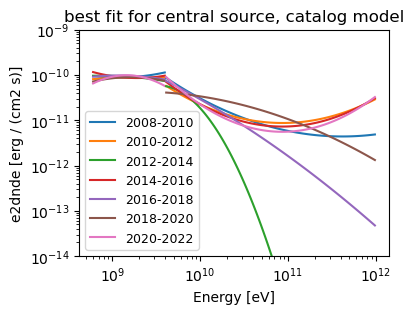

In [6]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            label=None
            if dataset_idx==2:
                label=time_label[n_bin_met]

            datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
                energy_bounds=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV, label=label, 
                color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
            ax=ax)
plt.ylim(1e-14, 1e-9)
plt.legend(prop={'size': 9})
plt.title('best fit for central source, catalog model')
plt.show()

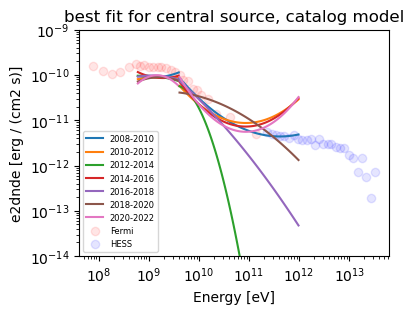

In [7]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):
            label=None
            if dataset_idx==2:
                label=time_label[n_bin_met]

            datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
                energy_bounds=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV, label=label, 
                color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"), 
            ax=ax)
for i, fp_name in enumerate(flux_points):
    ax.scatter(fp_name[:, 0], fp_name[:, 1], color=colors[i], label=names[i], alpha=0.1)
plt.ylim(1e-14, 1e-9)
plt.legend(prop={'size': 6})
plt.title('best fit for central source, catalog model')
plt.show()

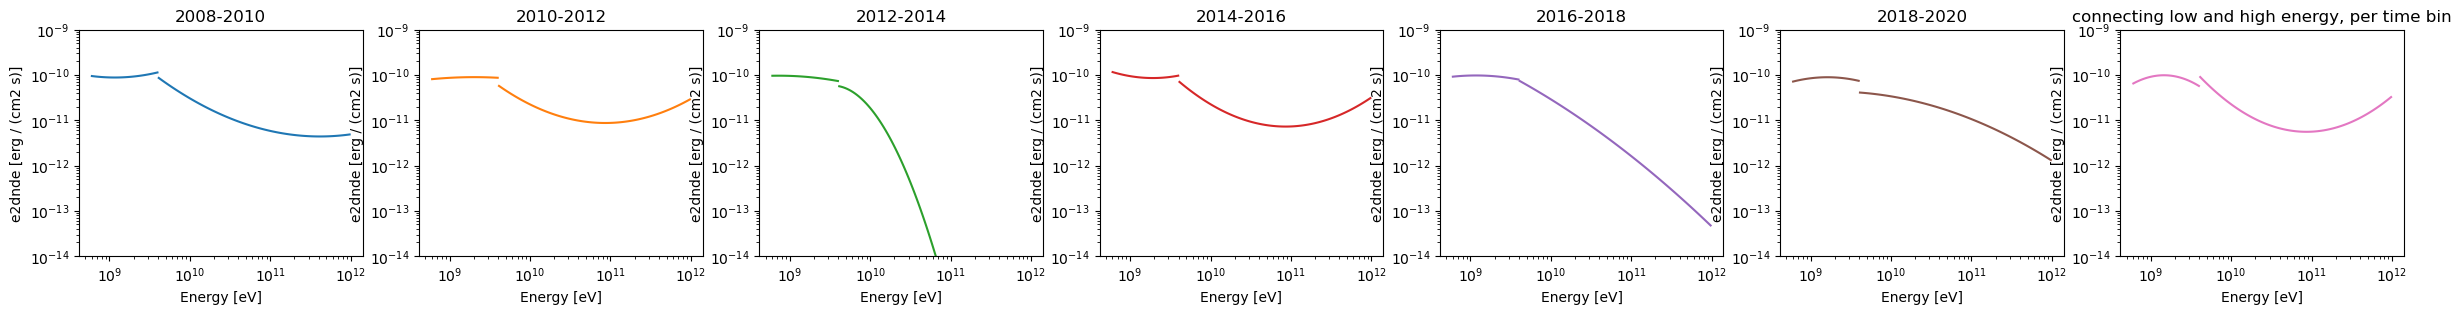

In [9]:
fig, ax = plt.subplots(1,7, figsize=(30, 3), dpi=100)

for n_bin_met in range(N_bin_met-1):
    for dataset_idx, dataset_name in enumerate(dataset_names):
        if dataset_idx != 0:
            datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
                energy_bounds=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV, label=n_bin_met, 
                color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
                ax=ax[n_bin_met])
    ax[n_bin_met].set_ylim(1e-14, 1e-9)
    ax[n_bin_met].set_title(time_label[n_bin_met])
plt.title('connecting low and high energy, per time bin')
plt.show()

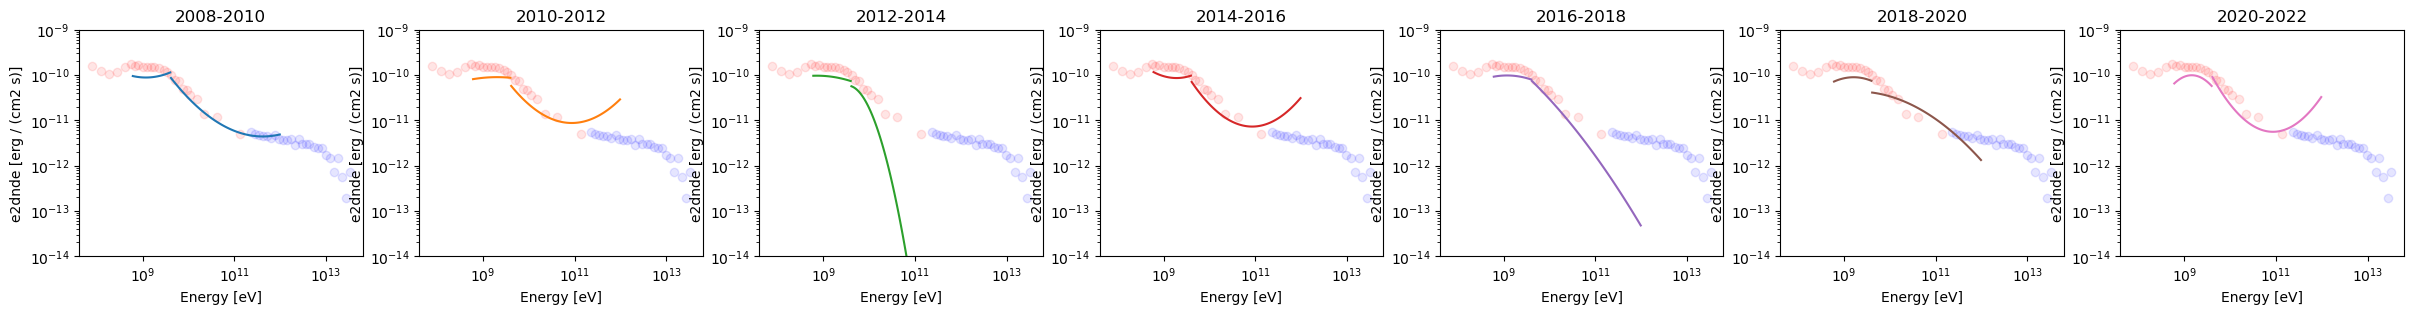

In [10]:
fig, ax = plt.subplots(1,7, figsize=(30, 3), dpi=100)

for n_bin_met in range(N_bin_met-1):
    for dataset_idx, dataset_name in enumerate(dataset_names):
        if dataset_idx != 0:
            datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
                energy_bounds=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV, label=n_bin_met, 
                color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.eV, yunits=u.Unit("erg cm-2 s-1"),
                ax=ax[n_bin_met])
    ax[n_bin_met].set_ylim(1e-14, 1e-9)
    ax[n_bin_met].set_title(time_label[n_bin_met])
    for i, fp_name in enumerate(flux_points):
        ax[n_bin_met].scatter(fp_name[:, 0], fp_name[:, 1], color=colors[i], label=names[i], alpha=0.1)
plt.show()

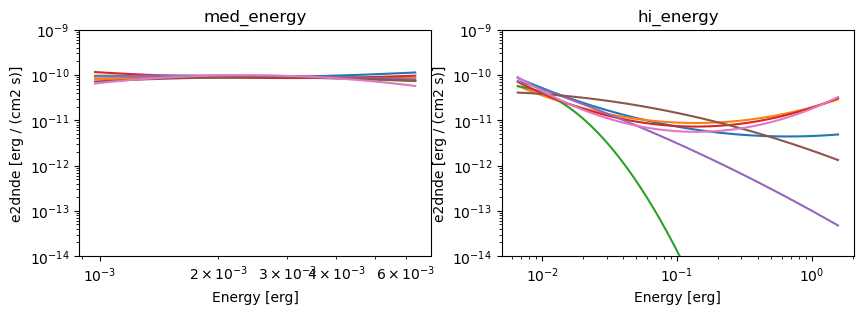

In [12]:
fig, ax = plt.subplots(1,2, figsize=(10, 3), dpi=100)

for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):    
            datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
                energy_bounds=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV, label=n_bin_met, 
                color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.erg, yunits=u.Unit("erg cm-2 s-1"), ax=ax[dataset_idx-1])
        ax[dataset_idx-1].set_title(dataset_names[dataset_idx])   
        ax[dataset_idx-1].set_ylim(1e-14, 1e-9)

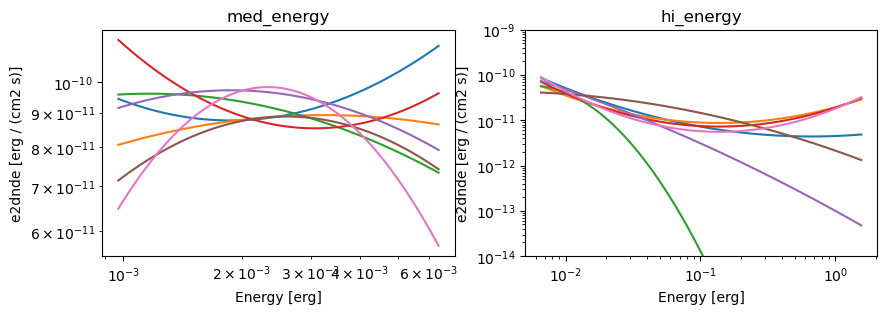

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10, 3), dpi=100)

for dataset_idx, dataset_name in enumerate(dataset_names):
    if dataset_idx != 0:
        for n_bin_met in range(N_bin_met-1):    
            datasets_binmet[dataset_idx][n_bin_met].models['4FGL J1745.6-2859'].spectral_model.plot(
                energy_bounds=[dataset_e_edges[dataset_idx], dataset_e_edges[dataset_idx+1]]*u.MeV, label=n_bin_met, 
                color=f'C{n_bin_met}', sed_type="e2dnde", xunits=u.erg, yunits=u.Unit("erg cm-2 s-1"), ax=ax[dataset_idx-1])
        ax[dataset_idx-1].set_title(dataset_names[dataset_idx])  
        if dataset_idx==2:
            ax[dataset_idx-1].set_ylim(1e-14, 1e-9)